# TECHNICAL STOCK ANALYSIS PLATFORM

## INTRODUCTION

As an investor struggling to efficiently track and analyze my portfolio, I identified a gap in accessible technical analysis tools. This inspired me to build an interactive platform that transforms complex financial data into actionable insights. Users can now seamlessly compare stocks, visualize key indicators like RSI and moving averages, and receive clear interpretations all within an intuitive interface designed for both novice and experienced traders.

## Import relevant libraries

In [1]:
#Test all imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ta import momentum, trend
from datetime import datetime, timedelta
import warnings
import requests
import time
warnings.filterwarnings('ignore')

print("All packages imported successfully!")

All packages imported successfully!


## Process flow & Architecture

The platform follows a modular architecture where each component handles a specific responsibility in the data pipeline. The sequential workflow is outlined below:

## 1. Data Acquisition Layer

**Functions**: *safe_yfinance_download()*, *get_stock_data()*
- **Purpose**: Fetches real-time market data from Yahoo Finance API with robust error handling.
- **Features**: Automatic retry mechanisms, fallback to simulated data during API outages, support for customizable time periods (1mo to 10Y)
- **Output**: Clean, structured OHLCV (Open-High-Low-Close-Volume) data

## 2. Technical Analysis Engine

**Function**: *calculate_technical_indicators()*

- **Purpose**: Computes key technical indicators from price data
- **Indicators Calculated**:
-- Trend Indicators: Simple Moving Average (SMA-20, SMA-50), Exponential Moving Average(EMA-12, EMA-26)
-- Momentum Indicators: Relative Strength Index (RSI) with 14-period lookback
-- Oscillator Indicators: MACD (Moving Average Convergence Divergence) with signal line and histogram
- **Methodology**: Implements standard financial formulas with proper rolling window calculations

## 3. Interactive User Interface

**Functions**: *interactive_stock_selection(), select_period()

- **Purpose**: Provides intuitive stock discovery and timeframe selection
- **Features**: Real-time stock search by company name/ticker, predefined period options, input validation
-- **User Experience**: Guided workflow with clear prompts and error handling

## 4. Visualization & Analytics Layer

**Functions**: *compare_two_stocks()*, *display_statistics_only()*, *plot_price_comparison()*
- **Tabular Analysis**: *display_statistics_only()* generates key metrics including current price, performace percentages, volatility, RSI status, and moving average signals
- **Visual Analysis**: *plot_price_comparison()* creates multi-panel charts showing:

-- Price action with SMA/EMA overlays

-- Volume trends

-- RSI momentum indicators

-- Automated technical interpretations (Overbought/Oversold signals)

## 5. Main Application Controller

**Function**: *interactive_stock_comparison()
- **Purpose**: interconnects the entire workflow from user input to final ouput
- **Flow**: Stock search --> period selection --> data fetching --> analysis --> visualization
- **Output**: Comprehensive comparison report with both stattistical summary and interactive charts




## Key Technical Features

- Modular design: each function has single responsibility
- Error resilience: API limits and network issues are handled gracefully
- Real-time processing: live data with calculated indicators
- User centric interface: users with no prior financial knowledge can use the platform with ease
- Professional output: institutional-grade analysis accessible to retail investors

This architecture ensures scalability, maintainability, and a seamless user experience while handling the complexities of financial data processing.

### Data Acquisition Layer

In [2]:
# Simple retry with delay

def safe_yfinance_download(symbol, retries=3, delay=2):
    for i in range(retries):
        try:
            data = yf.download(symbol, period="1mo", progress=False)
            if not data.empty:
                return data
        except Exception as e:
            print(f"Attempt {i+1} failed: {e}")
            time.sleep(delay)  # Wait before retry
    print("All attempts failed. Using simulated data instead.")
    return create_realistic_stock_data(symbol)

# Test with retry
#print("Testing with retry mechanism...")
#data = safe_yfinance_download("IREN")
#print(f"Final data shape: {data.shape}")

#The above approach worked so we'll be adopting that

In [3]:
#Data fetching function
#def get_stock_data(ticker, period = "3mo"):

#   for i in range(3):
#       try:
#           data = yf.download(ticker,period=period, progress = False)
#           if not data.empty:
#               return data
#       except:
#           time.sleep(2)
#   print(f"Could not fetch {ticker}, using simulated data")
#   return create_realistic_stock_data(ticker)


In [23]:
def get_stock_data(ticker, period="3mo"):
    """Safely fetch stock data and return with simple column names"""

    for i in range(3):
        try:
            data = yf.download(ticker, period=period, progress=False)
            if not data.empty:
                # Handle MultiIndex columns explicitly
                if hasattr(data.columns, 'levels') and len(data.columns.levels) > 1:
                    # We have MultiIndex columns - extract just the price type level
                    simple_columns = [col[0] for col in data.columns]
                    data.columns = simple_columns
                return data
        except:
            time.sleep(2)
    print(f"Could not fetch {ticker}, using simulated data")
    return create_realistic_stock_data(ticker)

In [5]:
#set up plotting
#plt.style.use('seaborn-v0_8')
%matplotlib inline

In [25]:
#Calculate technical indicators

def calculate_technical_indicators(data):
    """Calculate RSI, SMA, EMA and other indicators"""
    df = data.copy().reset_index() if hasattr(data.index, 'levels') else data.copy()

    #Simple moving averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    #Exponential Moving Averages
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

    #RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta>0,0)).rolling(window=14).mean()
    loss = (delta.where(delta<0,0)).rolling(window=14).mean()
    rs = gain/loss
    df['RSI'] = 100 - (100/(1+rs))

    #MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    #bollinger bands
    bb_middle = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    bb_upper = bb_middle + (bb_std * 2)
    bb_lower = bb_middle -(bb_std * 2)
    
    #Assign to Dataframe
    df['BB_Middle'] = bb_middle
    df['BB_Upper'] = bb_upper
    df['BB_Lower'] = bb_lower
    
    denominator = bb_upper - bb_lower
    denominator = denominator.replace(0, np.nan)
    bb_percent_b = (df['Close'] - bb_lower) / denominator
    
    df['BB_%B'] = bb_percent_b
    df['BB_Width'] = (bb_upper - bb_lower) / bb_middle
    
    #Bollinger band signals
    df['BB_Signal'] = 'Neutral'
    df.loc[df['Close'] >= bb_upper, 'BB_Signal'] = 'Overbought'
    df.loc[df['Close'] <= bb_lower, 'BB_Signal'] = 'Oversold'
    
    #Squeeze indicator
    if len(df) > 50:
        squeeze_threshold = df['BB_Width'].rolling(50).quantile(0.25)
        df['BB_Squeeze'] = df['BB_Width'] < squeeze_threshold
    else:
        df['BB_Squeeze'] = False
    
    #set index back if we reset it
    if hasattr(data.index, 'levels'):
        df = df.set_index(data.index.names)
    return df

    

### Technical Analysis Engine 

In [27]:
#Test with fetched data
print("Testing technical indicators...")
aapl_data = get_stock_data("AAPL")
aapl_with_indicators = calculate_technical_indicators(aapl_data)

print("Technical indicators calculated:")
print(f"Columns:{list(aapl_with_indicators.columns)}")
print(aapl_with_indicators.tail()[['Close','SMA_20','EMA_12','RSI','BB_Signal']])

Testing technical indicators...
Technical indicators calculated:
Columns:['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_%B', 'BB_Width', 'BB_Signal', 'BB_Squeeze']
                 Close      SMA_20      EMA_12         RSI   BB_Signal
Date                                                                  
2025-11-21  271.489990  269.942412  269.249304  536.516295     Neutral
2025-11-24  275.920013  270.310930  270.275567  291.945182  Overbought
2025-11-25  276.970001  270.722456  271.305480  266.230022  Overbought
2025-11-26  277.549988  271.128015  272.266173  242.001776     Neutral
2025-11-28  278.850006  271.513658  273.279071  195.112605     Neutral


### Visualisation and Analytics Layer

In [28]:
#Calculate statistics

def calculate_statistics(stock_data, ticker):
    """Calculate key statistics for a stock"""
    stats = {}

    #Basic stats
    stats['Ticker'] = ticker
    stats['Current Price'] = float(stock_data['Close'].iloc[-1]) #force to float
    stats['Price Change (%)'] = float(((stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[0])
                                 /stock_data['Close'].iloc[0])*100)

    #Volatility (standard deviation of returns)
    returns = stock_data['Close'].pct_change().dropna()
    stats['Volatility (%)'] = float(returns.std() *100*np.sqrt(252)) #Annualized

    #RSI status
    current_rsi = float(stock_data['RSI'].iloc[-1])
    if current_rsi > 70:
        rsi_status = "Overbought"
    elif current_rsi < 30:
        rsi_status = "Oversold"
    else:
        rsi_status = "Neutral"
    stats['RSI'] = f"{current_rsi:.1f} ({rsi_status})"

    #Moving average signals
    current_close = float(stock_data['Close'].iloc[-1])
    current_sma_20 = float(stock_data['SMA_20'].iloc[-1])
    
    if current_close > current_sma_20:
        ma_signal = "Above SMA20"
    else:
        ma_signal = "Below SMA20"
    stats['MA Signal'] = ma_signal
    
    #Bollinger Band statistics
    current_bb_signal = stock_data['BB_Signal'].iloc[-1]
    current_bb_percentb = float(stock_data['BB_%B'].iloc[-1])
    current_bb_width = float(stock_data['BB_Width'].iloc[-1])
    bb_squeeze = bool(stock_data['BB_Squeeze'].iloc[-1])
    
    #Bollinger Band interpretation
    if current_bb_signal == 'Overbought':
        bb_interpretation = "Price near upper band - potential resistance"
    elif current_bb_signal == 'Oversold':
        bb_interpretation = "Price near lower band - potential support"
    else:
        bb_interpretation = "Price within bands - normal range"
    
    stats['BB Position'] = f"{current_bb_signal} (%B: {current_bb_percentb:.2f})"
    stats['BB Width'] = f"{current_bb_width:.4f}"
    stats['BB Squeeze'] = "Yes" if bb_squeeze else "No"
    stats['BB Interpretation'] = bb_interpretation

    return stats
    
    

In [29]:
#Create comparison charts

def compare_two_stocks(ticker1, ticker2, period="3mo"):
    """Compare two stocks side by side"""
    #fetch data for both stocks
    stock1_data = get_stock_data(ticker1, period)
    stock2_data = get_stock_data(ticker2, period)

    #Calculate indicators
    stock1_tech = calculate_technical_indicators(stock1_data)
    stock2_tech = calculate_technical_indicators(stock2_data)

    return stock1_tech, stock2_tech

def display_statistics_only(stock1_data, stock2_data, ticker1, ticker2):
    """Display only statistics in a clean format"""
    stats1 = calculate_statistics(stock1_data, ticker1)
    stats2 = calculate_statistics(stock2_data, ticker2)

    import pandas as pd
    stats_df = pd.DataFrame([stats1, stats2])

    print("COMPARISON STATISTICS")
    print("=" * 60)
    print(stats_df.to_string(index=False))
    print("=" * 60)

    return stats_df
    



In [30]:
stock1, stock2 = compare_two_stocks("IREN", "CIFR")
stats_df = display_statistics_only(stock1, stock2, "IREN","CIFR")

COMPARISON STATISTICS
Ticker  Current Price  Price Change (%)  Volatility (%)                RSI   MA Signal        BB Position BB Width BB Squeeze                 BB Interpretation
  IREN      47.810001         80.551368      112.756563   -66.5 (Oversold) Below SMA20 Neutral (%B: 0.33)   0.7143         No Price within bands - normal range
  CIFR      20.350000        166.361266      133.341167 -1902.9 (Oversold) Above SMA20 Neutral (%B: 0.67)   0.7300         No Price within bands - normal range


In [41]:
def plot_price_comparison(stock1_data, stock2_data, ticker1, ticker2, 
                         show_sma=True, show_ema=True, show_volume=True, show_bollinger=True):
    """Enhanced comparison plot with technical indicators and volume as lines"""
    
    # Determine grid layout
    nrows = 2 if show_volume else 1
    fig, axes = plt.subplots(nrows, 2, figsize=(15, 5 * nrows))
    
    # Flatten axes for easier indexing
    if nrows == 2:
        ax1, ax2, ax3, ax4 = axes.flatten()
        ax_volume1, ax_volume2 = ax3, ax4
    else:
        ax1, ax2 = axes.flatten()
        ax_volume1, ax_volume2 = None, None
    
    # Plot 1: Stock 1 Price with Indicators
    ax1.plot(stock1_data.index, stock1_data['Close'], label=f'{ticker1} Close', 
             color='blue', linewidth=2)
    
    if show_sma:
        ax1.plot(stock1_data.index, stock1_data['SMA_20'], label=f'{ticker1} SMA 20',
                color='orange', linestyle='--', alpha=0.8)
        ax1.plot(stock1_data.index, stock1_data['SMA_50'], label=f'{ticker1} SMA 50',
                color='red', linestyle='--', alpha=0.8)
    
    if show_ema:
        ax1.plot(stock1_data.index, stock1_data['EMA_12'], label=f'{ticker1} EMA 12',
                color='green', linestyle='-.', alpha=0.8)
        ax1.plot(stock1_data.index, stock1_data['EMA_26'], label=f'{ticker1} EMA 26', 
                color='purple', linestyle='-.', alpha=0.8)
    
    # Add Bollinger Bands to stock 1 
    if show_bollinger and 'BB_Upper' in stock1_data.columns:
        ax1.fill_between(stock1_data.index, stock1_data['BB_Upper'], stock1_data['BB_Lower'],
                        alpha=0.2, color='gray', label=f'{ticker1} Bollinger Bands')
        ax1.plot(stock1_data.index, stock1_data['BB_Middle'], 
                color='gray', linestyle=':', alpha=0.7, label=f'{ticker1} BB Middle')
    
    # Add RSI as text annotation for stock 1
    current_rsi_1 = stock1_data['RSI'].iloc[-1]
    if current_rsi_1 > 70:
        rsi_color_1 = 'red'
        rsi_status_1 = 'Overbought'
    elif current_rsi_1 < 30:
        rsi_color_1 = 'green'
        rsi_status_1 = 'Oversold'
    else:
        rsi_color_1 = 'black'
        rsi_status_1 = 'Neutral'
    
    rsi_text_1 = f'RSI: {current_rsi_1:.1f} ({rsi_status_1})'
    ax1.text(0.98, 0.02, rsi_text_1, transform=ax1.transAxes, fontsize=12, horizontalalignment='right',
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=rsi_color_1),
             color=rsi_color_1, fontweight='bold')
    
    ax1.set_title(f'{ticker1} Price & Moving Averages')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Stock 2 Price with Indicators
    ax2.plot(stock2_data.index, stock2_data['Close'], label=f'{ticker2} Close',
             color='darkred', linewidth=2)
    
    if show_sma:
        ax2.plot(stock2_data.index, stock2_data['SMA_20'], label=f'{ticker2} SMA 20',
                color='orange', linestyle='--', alpha=0.8)
        ax2.plot(stock2_data.index, stock2_data['SMA_50'], label=f'{ticker2} SMA 50',
                color='red', linestyle='--', alpha=0.8)
    
    if show_ema:
        ax2.plot(stock2_data.index, stock2_data['EMA_12'], label=f'{ticker2} EMA 12',
                color='green', linestyle='-.', alpha=0.8)
        ax2.plot(stock2_data.index, stock2_data['EMA_26'], label=f'{ticker2} EMA 26',
                color='purple', linestyle='-.', alpha=0.8)
    
    # Bollinger Bands for stock2
    if show_bollinger and 'BB_Upper' in stock2_data.columns:
        ax2.fill_between(stock2_data.index, stock2_data['BB_Upper'], stock2_data['BB_Lower'],
                        alpha=0.2, color='lightcoral', label=f'{ticker2} Bollinger Bands')
        ax2.plot(stock2_data.index, stock2_data['BB_Middle'], 
                color='darkred', linestyle=':', alpha=0.7, label=f'{ticker2} BB Middle')
    
    # Add RSI as text annotation for stock 2
    current_rsi_2 = stock2_data['RSI'].iloc[-1]
    if current_rsi_2 > 70:
        rsi_color_2 = 'red'
        rsi_status_2 = 'Overbought'
    elif current_rsi_2 < 30:
        rsi_color_2 = 'green'
        rsi_status_2 = 'Oversold'
    else:
        rsi_color_2 = 'black'
        rsi_status_2 = 'Neutral'
    
    rsi_text_2 = f'RSI: {current_rsi_2:.1f} ({rsi_status_2})'
    ax2.text(0.98, 0.02, rsi_text_2, transform=ax2.transAxes, fontsize=12,
             verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=rsi_color_2),
             color=rsi_color_2, fontweight='bold')
    
    ax2.set_title(f'{ticker2} Price & Moving Averages')
    ax2.set_ylabel('Price')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3 & 4: Volume as LINE PLOTS 
    if show_volume and ax_volume1 is not None and ax_volume2 is not None:
        # Stock 1 Volume as line plot
        ax_volume1.plot(stock1_data.index, stock1_data['Volume'], 
                       alpha=0.8, color='blue', linewidth=1.5, label=f'{ticker1} Volume')
        ax_volume1.set_title(f'{ticker1} Volume')
        ax_volume1.set_ylabel('Volume')
        ax_volume1.grid(True, alpha=0.3)
        ax_volume1.legend()
        
        # Stock 2 Volume as line plot
        ax_volume2.plot(stock2_data.index, stock2_data['Volume'],
                       alpha=0.8, color='darkred', linewidth=1.5, label=f'{ticker2} Volume')
        ax_volume2.set_title(f'{ticker2} Volume')
        ax_volume2.set_ylabel('Volume')
        ax_volume2.grid(True, alpha=0.3)
        ax_volume2.legend()
    
    plt.tight_layout()
    return fig

### Interactive User Interface

In [34]:
def search_stocks(query, max_results=10):
    """
    Search for stocks by company name or ticker using Yahoo Finance
    Returns list of (ticker, company_name, exchange) tuples
    """
    try:
        # Yahoo Finance search endpoint
        url = f"https://query1.finance.yahoo.com/v1/finance/search"
        params = {
            'q': query,
            'quotesCount': max_results,
            'newsCount': 0,
            'enableFuzzyQuery': False
        }
        
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, params=params, headers=headers, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            results = []
            
            for quote in data.get('quotes', []):
                ticker = quote.get('symbol', '')
                name = quote.get('longname') or quote.get('shortname', '')
                exchange = quote.get('exchange', '')
                
                # Filter for actual stocks (not indices, crypto, etc.)
                if (ticker and name and 
                    exchange in ['NYSE', 'NASDAQ', 'NMS', 'NYQ', 'BTS'] and
                    not any(x in ticker for x in ['^', '=', '-'])):
                    results.append((ticker, name, exchange))
            
            return results[:max_results]
        else:
            print(f"Search API returned status: {response.status_code}")
            return []
            
    except Exception as e:
        print(f"Search error: {e}")
        return []



In [35]:
# Predefined period options for consistent analysis

PERIOD_OPTIONS = {
    '1': ('1mo', '1 Month'),
    '2': ('3mo', '3 Months'),
    '3': ('6mo', '6 Months'),
    '4': ('1y', '1 Year'),
    '5': ('2y', '2 Years'),
    '6': ('5y', '5 Years'),
    '7': ('10y', '10 Years'),
    '8': ('max', 'Maximum Available')
}

def select_period():
    """Interactive period selection"""
    print("\n SELECT ANALYSIS PERIOD:")
    print("-" * 40)
    for key, (period_code, period_name) in PERIOD_OPTIONS.items():
        print(f"{key}. {period_name}")
    print("-" * 40)

    while True:
        choice = input("Choose period (1-8): ").strip()
        if choice in PERIOD_OPTIONS:
            period_code, period_name = PERIOD_OPTIONS[choice]
            print(f"Selected: {period_name}")
            return period_code, period_name
        else:
            print("Please enter a number between 1 and 8")

In [36]:
def interactive_stock_selection(prompt_message="Select a stock:"):
    """
    Interactive stock selection with search
    Returns selected ticker
    """
    while True:
        print(f"\n{prompt_message}")
        search_term = input("Enter company name or ticker: ").strip()
        
        if not search_term:
            print("Please enter a search term.")
            continue
            
        print(f"Searching for '{search_term}'...")
        results = search_stocks(search_term)
        
        if not results:
            print("No results found. Try a different search term.")
            continue
            
        print(f"\n📈 Found {len(results)} results:")
        print("-" * 60)
        for i, (ticker, name, exchange) in enumerate(results, 1):
            print(f"{i}. {ticker} - {name} ({exchange})")
        print("-" * 60)
        
        try:
            selection = input(f"Select (1-{len(results)}) or 'r' to search again: ").strip().lower()
            
            if selection == 'r':
                continue
                
            selection_idx = int(selection) - 1
            if 0 <= selection_idx < len(results):
                selected_ticker, selected_name, exchange = results[selection_idx]
                print(f"Selected: {selected_ticker} - {selected_name}")
                return selected_ticker
            else:
                print(f"Please enter a number between 1 and {len(results)}")
                
        except ValueError:
            print("Please enter a valid number or 'r' to search again")

In [37]:
#interactive comparison function with search functionality
def interactive_stock_comparison():
    """Interactive function to compare any two stocks"""
    print("STOCK COMPARISON PLATFORM")
    print("=" * 50)

    # Get stocks through search
    print("\nSELECT FIRST STOCK:")
    ticker1 = interactive_stock_selection("Select first stock to compare")

    print("\nSELECT SECOND STOCK:")
    ticker2 = interactive_stock_selection("Select second stock to compare")

    # Get period selection
    period_code, period_name = select_period()

    # Get visualization preferences
    print("\n Visualization Options:")
    show_sma = input("Show SMA? (y/n): ").lower() == 'y'
    show_ema = input("Show EMA? (y/n): ").lower() == 'y'
    show_volume = input("Show Volume? (y/n): ").lower() == 'y'

    print(f"\n Comparing {ticker1} vs {ticker2} over {period_name}.")

    #fetch data with selected period
    stock1, stock2 = compare_two_stocks(ticker1, ticker2,period_code)

    #Display statistics only
    #print("COMPARISON STATISTICS:")
    #print("=" * 60)
    #stats_df = display_statistics_only(stock1, stock2, ticker1, ticker2)

    
    #Plot comparison
    plot_price_comparison(stock1, stock2, ticker1, ticker2, show_sma=show_sma,
                         show_ema=show_ema, show_volume=show_volume)


    return stats_df
    

In [38]:
def robust_stock_search(query, max_results=10):
    """
    Enhanced search with multiple fallback strategies
    """
    # Try Yahoo Finance first
    results = search_stocks(query, max_results)
    
    if results:
        return results
    
    # Fallback: Try direct yfinance lookup for exact ticker matches
    try:
        stock = yf.Ticker(query.upper())
        info = stock.info
        if info.get('longName'):
            return [(query.upper(), info.get('longName'), info.get('exchange', 'Unknown'))]
    except:
        pass
    
    return []

def search_and_validate_ticker(ticker):
    """
    Validate that a ticker exists and get its full name
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        name = info.get('longName') or info.get('shortName')
        if name:
            return True, name
        return False, "Ticker not found"
    except:
        return False, "Invalid ticker"

STOCK COMPARISON PLATFORM

SELECT FIRST STOCK:

Select first stock to compare
Enter company name or ticker: IREN
Searching for 'IREN'...

📈 Found 2 results:
------------------------------------------------------------
1. IREN - IREN Limited (NMS)
2. IREX - Tradr 2X Long IREN Daily ETF (BTS)
------------------------------------------------------------
Select (1-2) or 'r' to search again: 1
Selected: IREN - IREN Limited

SELECT SECOND STOCK:

Select second stock to compare
Enter company name or ticker: BITFARM
Searching for 'BITFARM'...
No results found. Try a different search term.

Select second stock to compare
Enter company name or ticker: ASST
Searching for 'ASST'...
No results found. Try a different search term.

Select second stock to compare
Enter company name or ticker: CIFR
Searching for 'CIFR'...

📈 Found 2 results:
------------------------------------------------------------
1. CIFR - Cipher Mining Inc. (NMS)
2. CIFU - T-REX 2X Long CIFR Daily Target (BTS)
-------------------

,Ticker,Current Price,Price Change (%),Volatility (%),RSI,MA Signal,BB Position,BB Width,BB Squeeze,BB Interpretation
0,IREN,47.810001,80.551368,112.756563,-66.5 (Oversold),Below SMA20,Neutral (%B: 0.33),0.7143,No,Price within bands - normal range
1,CIFR,20.350000,166.361266,133.341167,-1902.9 (Oversold),Above SMA20,Neutral (%B: 0.67),0.7300,No,Price within bands - normal range


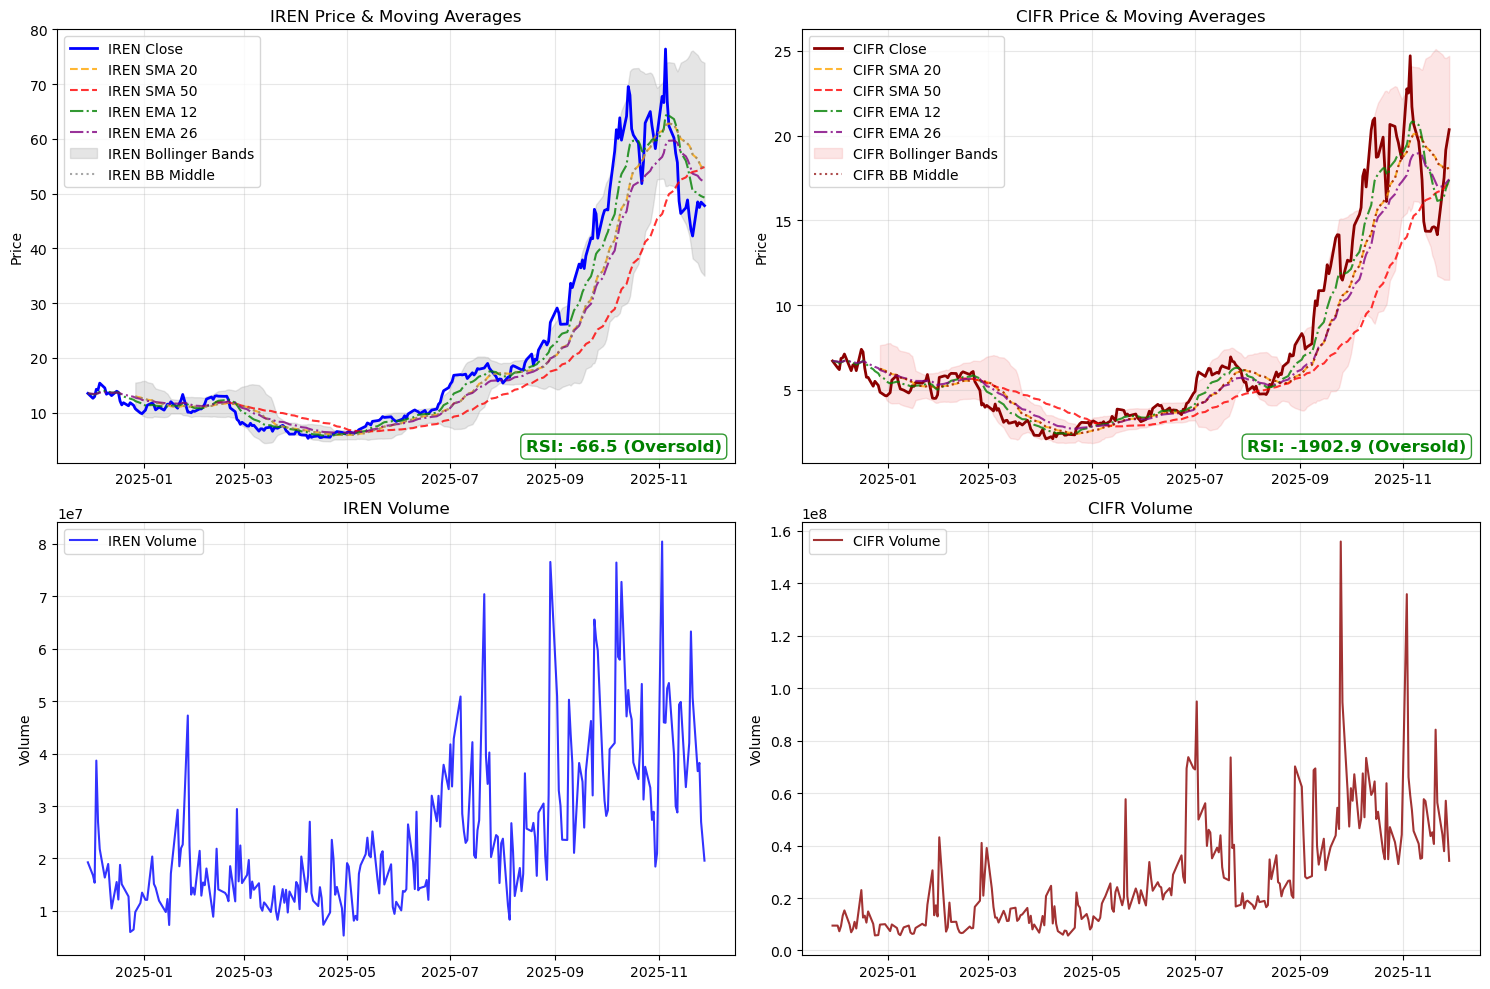

In [43]:
interactive_stock_comparison()

### Next Steps

- Include other technical indicators like bollinger bands, stochastic
- Enhance the platform to have portfolio tracking, alert system, export capabilities, and web interface.
